<a href="https://colab.research.google.com/github/Arunima1236/Datascience_nlp/blob/master/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Review Sentiment Analysis

**Features/Columns**: The dataset consists of review texts as the primary feature and corresponding sentiment labels. The review text captures user feedback on Spotify, while the sentiment labels categorize the nature of the reviews.

**Sentiment Labels**: The sentiment labels are binary, indicating whether a review is positive or negative. This classification helps in understanding overall user sentiment towards Spotify.

This dataset serves as an ideal foundation for building a sentiment analysis model, allowing the classification of user opinions and enhancing understanding of customer feedback.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
%pip install wordcloud

In [6]:
# load data

data = pd.read_csv('/content/drive/MyDrive/Datascience/project/NLP project/DATASET.csv')
data.head()

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE


# **Exploratory Data Analysis**

In [7]:
data.shape

(31217, 2)

In [8]:
data.describe

<bound method NDFrame.describe of                                                   Review     label
0      Great music service, the audio is high quality...  POSITIVE
1      Please ignore previous negative rating. This a...  POSITIVE
2      This pop-up "Get the best Spotify experience o...  NEGATIVE
3        Really buggy and terrible to use as of recently  NEGATIVE
4      Dear Spotify why do I get songs that I didn't ...  NEGATIVE
...                                                  ...       ...
31212  Was good maybe a month ago, starting to become...  NEGATIVE
31213  It was nice at first, but seriously? Having to...  NEGATIVE
31214  Uggg! So many issues with the latest rollout. ...  NEGATIVE
31215  I find that I'm constantly having to close out...  NEGATIVE
31216  It's the best music app available in the marke...  POSITIVE

[31217 rows x 2 columns]>

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31217 entries, 0 to 31216
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  31217 non-null  object
 1   label   31217 non-null  object
dtypes: object(2)
memory usage: 487.9+ KB


In [10]:
data.isnull().sum()

,0
Review,0
label,0


In [11]:
data.duplicated().sum()

213

In [12]:
data.drop_duplicates(inplace=True)

In [13]:
# Creating a new column 'length' that will contain the length of the string in 'Review' column
data['length'] = data['Review'].apply(len)

In [14]:
data.columns

Index(['Review', 'label', 'length'], dtype='object')

In [15]:
for i in data.columns:
  print(i)
  print(data[i].value_counts())
  print('*'*100)
  print(data[i].unique())

Review
Review
Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.                                                                                                                                                                                                                                               1
I really enjoy the podcasts & I enjoy the variety of shows that I can listen to. however I would like to see more of certain topics.                                                                                                                                                                                                                           1
I love the service of Spotify, but please @spotify-devs: why is this app so hard to use without or with bad internet connection - For downloaded playlists and podcast it takes forever to load and the whole ui responds so badly... Seems not like a complicated thing to fix, but is 

<ipython-input-16-0b32e0d6f99a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data,x='label',palette='plasma',edgecolor='black',linewidth=1)


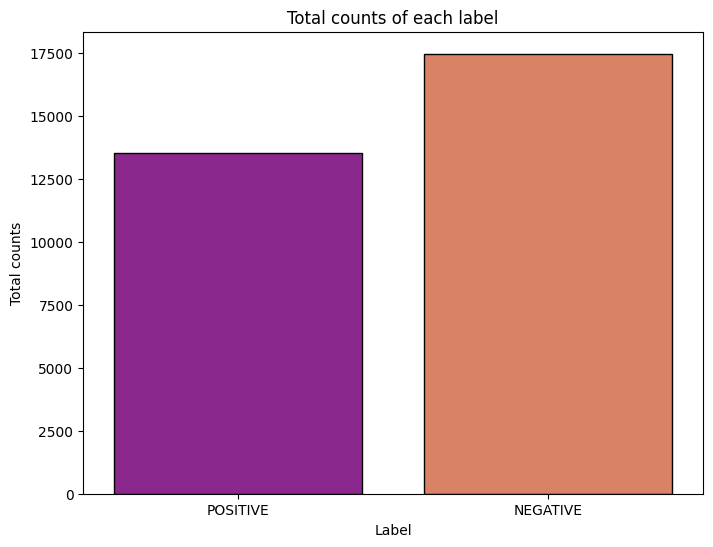

In [16]:
# Barplot to visualize the total counts of each label

plt.figure(figsize=(8,6))
sns.countplot(data=data,x='label',palette='plasma',edgecolor='black',linewidth=1)
plt.xlabel('Label')
plt.ylabel('Total counts')
plt.title('Total counts of each label')
plt.show()

In [17]:
# percentage distribution of label

data['label'].value_counts(normalize=True)*100




,proportion
label,
NEGATIVE,56.357244
POSITIVE,43.642756


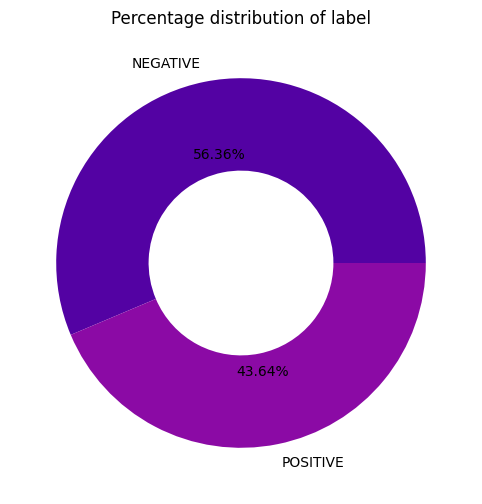

In [18]:
# create pie chart based on percentage of label

plt.figure(figsize=(8,6))
plt.pie(data['label'].value_counts(),labels=data['label'].value_counts().index,autopct='%1.2f%%',colors=sns.color_palette('plasma'),wedgeprops=dict(width=0.5))
plt.title('Percentage distribution of label')
plt.show()

In [19]:
data['length'].describe()

,length
count,31004.000000
mean,151.566766
std,121.932173
min,6.000000
25%,58.000000
50%,113.000000
75%,206.000000
max,1693.000000


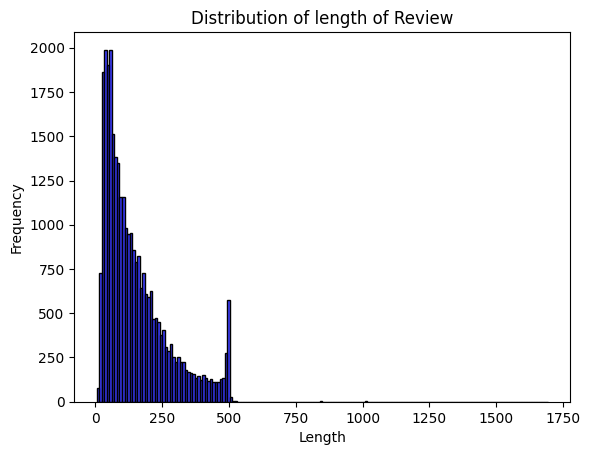

In [20]:
sns.histplot(data['length'],color='blue',edgecolor='black',linewidth=1)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of length of Review')
plt.show()

In [21]:
# To take text data and convert it into matrix token of counts
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.Review)


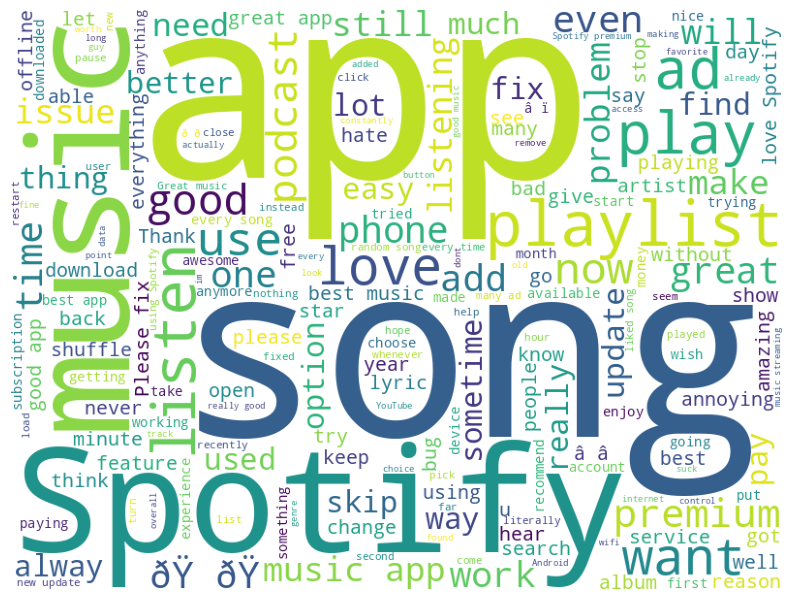

In [22]:
#Combine all reviews
reviews = " ".join([review for review in data['Review']])

#Initialize wordcloud object
wc = WordCloud(background_color="white", width=800, height=600)

#Generate and plot wordcloud
plt.figure(figsize=(10, 8))
plt.imshow(wc.generate(reviews))
plt.axis("off")
plt.show()

# **Processing and Modelling**

To build the corpus from the 'Review'
   1. Replace any non alphabet character with a space
   2. Covert to lower case and split into words
   3. Iterate over the individual words and if it is not a stopwords then add the stemmed(A technique to remove the suffixes from english words and obtain their stems) form of the word to the corpus.

In [23]:

corpus = []
stemmer = PorterStemmer()

In [24]:
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['Review'])
  review = review.lower()
  review = review.split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [25]:
data = data.dropna(subset=['label'])

In [26]:


#storing independent and dependent variable in X and Y.

x = pd.DataFrame({'tweet':corpus})
y = data['label']

In [27]:
# checking the shape of x and y
x.shape

(31004, 1)

In [28]:
y.shape

(31004,)

Spliting data into train and test with 30% data with testing.

In [29]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=15)

print("x_train : ", (x_train.shape))
print("x_test : ", {x_test.shape})
print("y_train : ", {y_train.shape})
print("y_test : ", {y_test.shape})

x_train :  (21702, 1)
x_test :  {(9302, 1)}
y_train :  {(21702,)}
y_test :  {(9302,)}


In [30]:
vectorizer = TfidfVectorizer()

In [31]:
x_train_vec = vectorizer.fit_transform(x_train['tweet'])
x_test_vec = vectorizer.transform(x_test['tweet'])

In [32]:
#scaling x_train and x_test
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_vec.toarray()) # Convert to dense array if necessary
x_test_scaled = scaler.transform(x_test_vec.toarray())

RANDOM FOREST MODEL

In [33]:
model_random = RandomForestClassifier()
model_random.fit(x_train_scaled,y_train)


RandomForestClassifier()

In [34]:
y_pred = model_random.predict(x_test_scaled)

Evaluating model

In [35]:
print("Training_score: ",model_random.score(x_train_scaled,y_train))
print("Testing_score: ",model_random.score(x_test_scaled,y_test))

Training_score:  0.9992627407612201
Testing_score:  0.8587400559019566


In [36]:
accuracy_random = accuracy_score(y_test,y_pred)
print("Accuracy: ",accuracy_random)

Accuracy:  0.8587400559019566


In [37]:
con_metrics = confusion_matrix(y_test,y_pred)
print(con_metrics)

[[4703  539]
 [ 775 3285]]


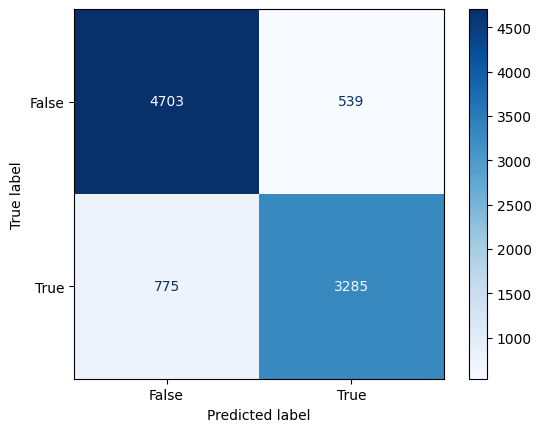

In [68]:
cm_display = ConfusionMatrixDisplay(con_metrics,display_labels=[False,True])
cm_display.plot(cmap='Blues')
plt.show()

In [39]:
print("classification report \n",classification_report(y_test,y_pred))


classification report 
               precision    recall  f1-score   support

    NEGATIVE       0.86      0.90      0.88      5242
    POSITIVE       0.86      0.81      0.83      4060

    accuracy                           0.86      9302
   macro avg       0.86      0.85      0.86      9302
weighted avg       0.86      0.86      0.86      9302



cross validation

In [40]:
accuracies = cross_val_score(estimator=model_random,X=x_train_scaled,y=y_train,cv=10)

print("Accuracy : ",accuracies.mean())
print("Standard Deviation : ",accuracies.std())

Accuracy :  0.8504751149951073
Standard Deviation :  0.0063200802918177805


In [69]:
accuracies

array([0.84983878, 0.84016582, 0.84976959, 0.84562212, 0.85023041,
       0.85299539, 0.84562212, 0.85576037, 0.86497696, 0.84976959])

Applying grid search to get optimal parameters on random forest

In [41]:
params = {
    'bootstrap' : [True],
    'max_depth' : [90,100],
    'min_samples_split' : [8,12],
    'n_estimators' : [100,300]

}

In [43]:
cv_object = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(estimator = model_random,param_grid=params,cv=cv_object,verbose=0,return_train_score=True)
grid_search.fit(x_train_scaled,y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [90, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [44]:
#getting the best parameters from grid search

print("Best parameter combination : {}",format(grid_search.best_params_))

Best parameter combination : {} {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [46]:
print("Cross validation mean accuracy on train set  : ",format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set  : ",format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set : ",accuracy_score(y_test,y_pred))

Cross validation mean accuracy on train set  :  98.18680305962584
Cross validation mean accuracy on test set  :  84.81418763247626
Accuracy score for test set : 0.8587400559019566


Logistic regression model

In [47]:
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression()
model_logistic.fit(x_train_scaled,y_train)

LogisticRegression()

In [48]:
y_pred1 = model_logistic.predict(x_test_scaled)

Evaluation

In [49]:
accuracy_logistic = accuracy_score(y_test,y_pred1)
print("Accuracy: ",accuracy_logistic)

Accuracy:  0.8318641152440336


In [50]:
con_metrics_logi = confusion_matrix(y_test,y_pred1)
print(con_metrics_logi)

[[4481  761]
 [ 803 3257]]


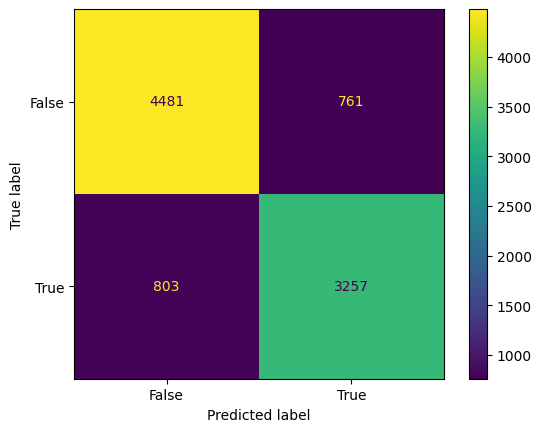

In [51]:
cm_display_logistic = ConfusionMatrixDisplay(con_metrics_logi,display_labels=[False,True])
cm_display_logistic.plot()
plt.show()

Decision Tree model

In [52]:
model_dc = DecisionTreeClassifier()
model_dc.fit(x_train_scaled,y_train)

DecisionTreeClassifier()

In [53]:
y_pred2 = model_dc.predict(x_test_scaled)

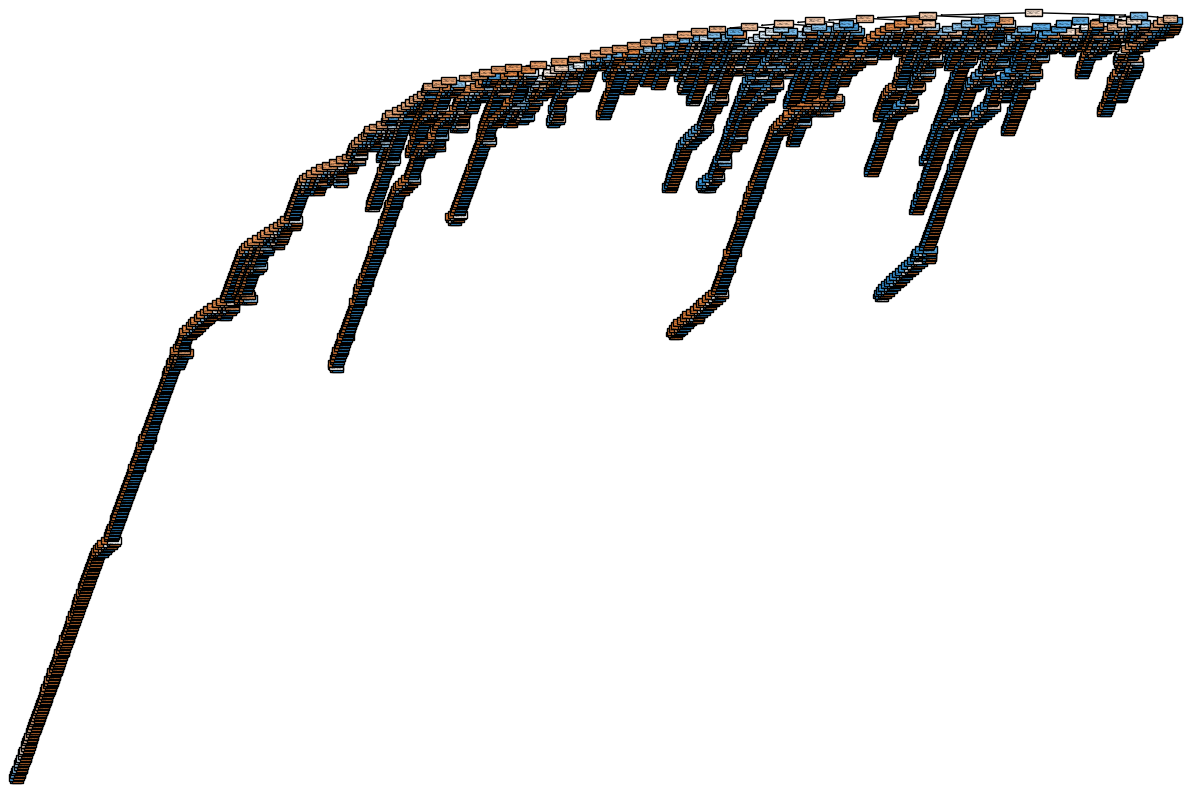

In [55]:
#plotting tree
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(model_dc,filled=True)
plt.show()

Evaluation of model

In [56]:
print("Training Score ",model_dc.score(x_train_scaled,y_train))
print("Testing Score ",model_dc.score(x_test_scaled,y_test))

Training Score  0.9992627407612201
Testing Score  0.7870350462266179


In [58]:
accuracy_dc = accuracy_score(y_test,y_pred2)
print("Accuracy: ",accuracy_dc)

Accuracy:  0.7870350462266179


In [60]:
conf_dc = confusion_matrix(y_test,y_pred2)
print(conf_dc)

[[4197 1045]
 [ 936 3124]]


Comparing Each models based on accuracy

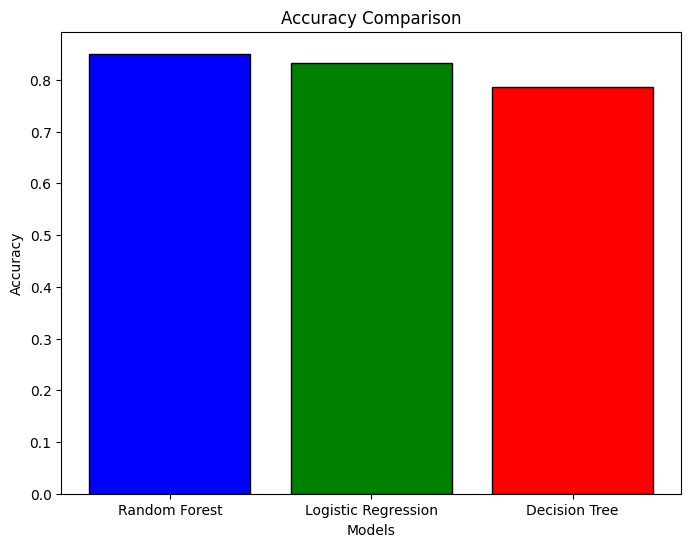

In [74]:
# creat a visualization for comparing accuracy of data
plt.figure(figsize=(8, 6))
# Removed palette='plasma'
plt.bar(['Random Forest', 'Logistic Regression', 'Decision Tree'], [accuracies.mean(), accuracy_logistic, accuracy_dc], color=['blue', 'green', 'red'], edgecolor='black', linewidth=1)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

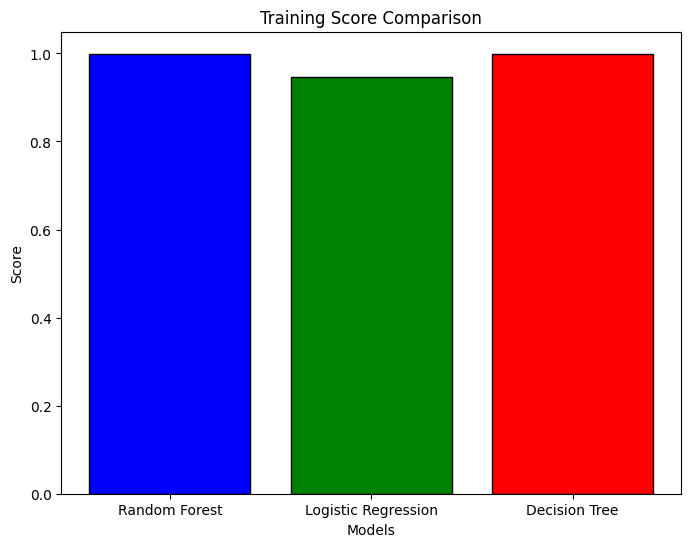

In [79]:
# comparing using visualization of training score of each models
plt.figure(figsize=(8, 6))
plt.bar(['Random Forest', 'Logistic Regression', 'Decision Tree'], [model_random.score(x_train_scaled,y_train), model_logistic.score(x_train_scaled,y_train), model_dc.score(x_train_scaled,y_train)], color=['blue', 'green', 'red'], edgecolor='black', linewidth=1)
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Training Score Comparison')
plt.show()


**New review prediction using Random forest model**

In [75]:
sample = 'Spotify is one of the best apps for streaming music. It lets you listen to your favorite songs, discover new ones, and create playlists. You can use it for free with ads or pay for Premium to enjoy music without ads, download songs, and get better sound quality. It’s easy to use and has a huge collection of songs, podcasts, and playlists for any mood or activity.'

In [76]:
result = model_random.predict(vectorizer.transform([sample]))
if result == 0:
  print("Negative")
else:
  print("Positive")

Positive


# **Conclusion**

In the NLP project on Spotify review sentiment analysis, the **Random Forest** model demonstrated superior performance with an accuracy of **85.04%**, outperforming Logistic Regression and Decision Tree models.

This indicates that Random Forest effectively captures complex patterns and interactions within the dataset, making it the most reliable choice for this task.

Logistic Regression is also a strong candidate. Decision Tree might not perform as well as the other two models but could still be useful depending on interpretability needs or specific use cases.